# Timeseries Analysis - Notebook 1
### João Vidigal

**Why is important to study Time Series?**  
They contain information about general tendency in the data, seasonal effects, occasional events, and so on...


Some of the most important and commonly used data science techniques to analyze time series data are those in developed in the field of statistics. For this reason, time series statistical models should be included in any data scientist's toolkit.



###  Table of contents 

* 1. [Data](#Data).

* 2. [Time Series Transformation](#TimeSeriesTransformation) 

* 3. [Exploratory Data Analysis](#ExploratoryData) 

* 4. [Window functions](#WindowFunctions)

* 5. [Split Data](#Splitting)

* 6. [Forecast](#Forecast)

     6.1. [Naive Approach](#NaiveApproach)  
     6.2. [Moving Average](#MovingAverage)  
     6.3. [Simple Exponential Smoothing](#SimpleExponential)  
     6.4. [Holt’s Linear](#Holt’sLinear)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import hvplot.pandas
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, add_trend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id="Data"></a>
## Data
 
**Data:** Apple stocks daily values since 2015.

First, we import all the datasets needed for this kernel. The required time series column is imported as a datetime column using **parse_dates** parameter and is also selected as index of the dataframe using **index_col** parameter.

In [2]:
appl_df = pd.read_csv('data/appl_2015.csv', parse_dates=['date'])
appl_df.head()

,date,open,high,low,close,adjclose,volume
0,2015-01-02,111.389999,111.440002,107.349998,109.330002,100.755898,53204600
1,2015-01-05,108.290001,108.650002,105.410004,106.250000,97.917427,64285500
2,2015-01-06,106.540001,107.430000,104.629997,106.260002,97.926666,65797100
3,2015-01-07,107.199997,108.199997,106.699997,107.750000,99.299805,40105900
4,2015-01-08,109.230003,112.150002,108.699997,111.889999,103.115128,59364500


Check if date is in the correct type form.

In [3]:
appl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 7 columns):
date        1178 non-null datetime64[ns]
open        1178 non-null float64
high        1178 non-null float64
low         1178 non-null float64
close       1178 non-null float64
adjclose    1178 non-null float64
volume      1178 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 64.5 KB


<a id="TimeSeriesTransformation"></a>
## Time series transformation
### Lag 
Shifts time series but preserve the index.

In [4]:
appl_df.shift().head()

,date,open,high,low,close,adjclose,volume
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,111.389999,111.440002,107.349998,109.330002,100.755898,53204600.0
2,2015-01-05,108.290001,108.650002,105.410004,106.250000,97.917427,64285500.0
3,2015-01-06,106.540001,107.430000,104.629997,106.260002,97.926666,65797100.0
4,2015-01-07,107.199997,108.199997,106.699997,107.750000,99.299805,40105900.0


### Difference
Calculate the difference between the lag and the original data.  
Taking the difference between consecutive observations is called a lag-1 difference.

In [5]:
appl_df.diff().head()

,date,open,high,low,close,adjclose,volume
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,3 days,-3.099998,-2.790001,-1.939995,-3.080002,-2.838470,11080900.0
2,1 days,-1.750000,-1.220001,-0.780006,0.010002,0.009239,1511600.0
3,1 days,0.659996,0.769997,2.070000,1.489998,1.373138,-25691200.0
4,1 days,2.030006,3.950005,2.000000,4.139999,3.815323,19258600.0


## Feature Extraction

We will extract the time and date from the Datetime. We have seen earlier that the data type of Datetime is object. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [6]:
def weekend_bool(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 

appl_df['year']= appl_df.date.dt.year 
appl_df['month']= appl_df.date.dt.month 
appl_df['day']= appl_df.date.dt.day
appl_df['day of week']=appl_df.date.dt.dayofweek 

appl_df['weekend'] = appl_df.date.apply(weekend_bool) 
 

### Select data from this year (2019) for a shorter dataset

In [7]:
#appl_df = appl_df[appl_df['date']>= '2019-01-01']

### Set Date as index

In [8]:
appl_df.set_index('date',inplace=True)

### Percent change and Stock returns

In [9]:
appl_df['change'] = appl_df.adjclose.div(appl_df.adjclose.shift())
appl_df['return'] = appl_df.change.sub(1).mul(100)
appl_df['AbsChange'] = appl_df.adjclose.diff()

In [10]:
appl_df['normalized'] = appl_df.adjclose.div(appl_df.adjclose.iloc[0]).mul(100)

<a id="ExploratoryData"></a>
## Exploratory Data analysis
Visualizing the data

In [11]:
(appl_df[['low','close','high']].hvplot() + 
  appl_df[['low','close','high']].describe().reset_index().hvplot.table( width=300))

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Table.I     :Table   [index,low,close,high]

In [12]:
(appl_df.hvplot.box('adjclose', by='year') +
 appl_df.groupby('year')['adjclose'].mean().reset_index().hvplot.table(['year', 'adjclose'], width=200))

:Layout
   .BoxWhisker.I :BoxWhisker   [year]   (adjclose)
   .Table.I      :Table   [year,adjclose]

### Return by year

In [13]:
(appl_df.hvplot.box('return', by='year') +
 (appl_df.groupby('year')['return'].mean()).reset_index().hvplot.table(['year', 'return'], width=200))

:Layout
   .BoxWhisker.I :BoxWhisker   [year]   (return)
   .Table.I      :Table   [year,return]

<a id="WindowFunctions"></a>
## Window functions - Smooth out your timeseries data

### Rolling mean - smoother version of the original timeseries plot but with lag.

Now, observe that rolling mean plot is a smoother version of the original plot but with lag.

### Window size 
**shorter windows** - closer to timeseries data, but without noise.  
**long windows** - if we are interested in long term trends.

In [14]:
appl_df['RollingMean30'] = appl_df['adjclose'].rolling(window=30).mean()
appl_df['RollingMean90'] = appl_df['adjclose'].rolling(window=90).mean()
appl_df[['adjclose','RollingMean30','RollingMean90']].hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

### Min and Max and other functions in the window function

Accuratly describes the min and max values for that window period in the timeseries

In [15]:
appl_df['RollingMin'] = appl_df['adjclose'].rolling(window=30).min()
appl_df['RollingMax'] = appl_df['adjclose'].rolling(window=30).max()
appl_df[['adjclose','RollingMin','RollingMax']].hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

## Expanding window

When you have knowledge that all your data is just as valide as the new. Not commonly used.

In [16]:
appl_df['ExpandingMean'] = appl_df['adjclose'].expanding().mean()
appl_df[['adjclose','ExpandingMean']].hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

## Exponential weight moving average

The weighted moving average (WMA) gives you a weighted average of the last n prices, where the weighting decreases with each previous price. Because an exponential moving average (EMA) uses an exponentially weighted multiplier to give more weight to recent prices, some believe it is a better indicator of a trend.

In [17]:
appl_df['RollingWeiMean'] = appl_df['adjclose'].ewm(span = 30,  min_periods = 0, adjust = True).mean()

appl_df[['adjclose','RollingWeiMean']].hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

## Splitting the data into training and testing
we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.  

In [18]:
train_df=appl_df.loc[:'2019-06-30'] 
test_df=appl_df.loc['2019-07-01':]

In [19]:
(train_df.adjclose.hvplot(legend =False, title = 'Train vs Test', ylabel = 'Value' ) * test_df.adjclose.hvplot(legend =False))

:Overlay
   .Curve.Adjclose.I  :Curve   [date]   (adjclose)
   .Curve.Adjclose.II :Curve   [date]   (adjclose)

### Metric to evaluate forecast

* We can calculate how accurate our predictions are using rmse(Root Mean Square Error).
* The rmse is the standard deviation of the residuals.
* Residuals are a measure of how far from the regression line data points are.

## Forecasting Methods

<a id="NaiveApproach"></a>
### i) Naive Approach 
In this forecasting technique, we assume that the next expected point is equal to the last observed point.

In [20]:
dd= np.asarray(train_df.adjclose) 
y_hat = test_df.copy() 
y_hat['naive'] = dd[len(dd)-1] 

rms = np.sqrt(mean_squared_error(test_df.adjclose, y_hat.naive)) 

(train_df.adjclose.hvplot(legend = False, title = f'Naive Approach, RMSE = {np.round(rms, 3)} ' , ylabel = 'Value') * 
 test_df.adjclose.hvplot(legend =False) *
y_hat['naive'].hvplot(legend = False))

print(f'The RMSE of the naive approach is {np.round(rms, 3)}')

:Overlay
   .Curve.Adjclose.I  :Curve   [date]   (adjclose)
   .Curve.Adjclose.II :Curve   [date]   (adjclose)
   .Curve.Naive       :Curve   [date]   (naive)

The RMSE of the naive approach is 9.08


<a id="NaiveApproach"></a>
### ii) Moving Average
In this technique we will take the average of the passenger counts for last few time periods only.

In [21]:
y_hat_avg = test_df.copy() 
y_hat_avg['moving_avg_forecast'] = train_df.adjclose.rolling(5).mean().iloc[-1] # average of last 5 observations.

rms = np.sqrt(mean_squared_error(test_df.adjclose, y_hat_avg['moving_avg_forecast'])) 

(train_df.adjclose.hvplot(legend = False, title = f'Moving Average, RMSE = {np.round(rms, 3)} ' , ylabel = 'Value') * 
 test_df.adjclose.hvplot(legend =False) *
y_hat_avg['moving_avg_forecast'].hvplot(legend = False))

:Overlay
   .Curve.Adjclose.I          :Curve   [date]   (adjclose)
   .Curve.Adjclose.II         :Curve   [date]   (adjclose)
   .Curve.Moving_avg_forecast :Curve   [date]   (moving_avg_forecast)

<a id="SimpleExponential"></a>
### iii) Simple Exponential Smoothing

* In this technique, we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

In [22]:
fit2 = SimpleExpSmoothing(np.asarray(train_df.adjclose)).fit(smoothing_level=0.48,optimized=True) 
y_hat_avg['SES'] = fit2.forecast(len(test_df)) 

rms = np.sqrt(mean_squared_error(test_df.adjclose, y_hat_avg['SES'])) 

(train_df.adjclose.hvplot(legend = False, title = f'Moving Average, RMSE = {np.round(rms, 3)} ' , ylabel = 'Value') * 
 test_df.adjclose.hvplot(legend =False) *
y_hat_avg['SES'].hvplot(legend = False))


:Overlay
   .Curve.Adjclose.I  :Curve   [date]   (adjclose)
   .Curve.Adjclose.II :Curve   [date]   (adjclose)
   .Curve.SES         :Curve   [date]   (SES)

<a id="Holt’sLinear"></a>
### iv) Holt’s Linear Trend Model

* It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
* This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

We can decompose the time series in four parts.

* Observed, which is the original time series.
* Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
* Seasonal, which tells us about the seasonality in the time series.
* Residual, which is obtained by removing any trend or seasonality in the time series.

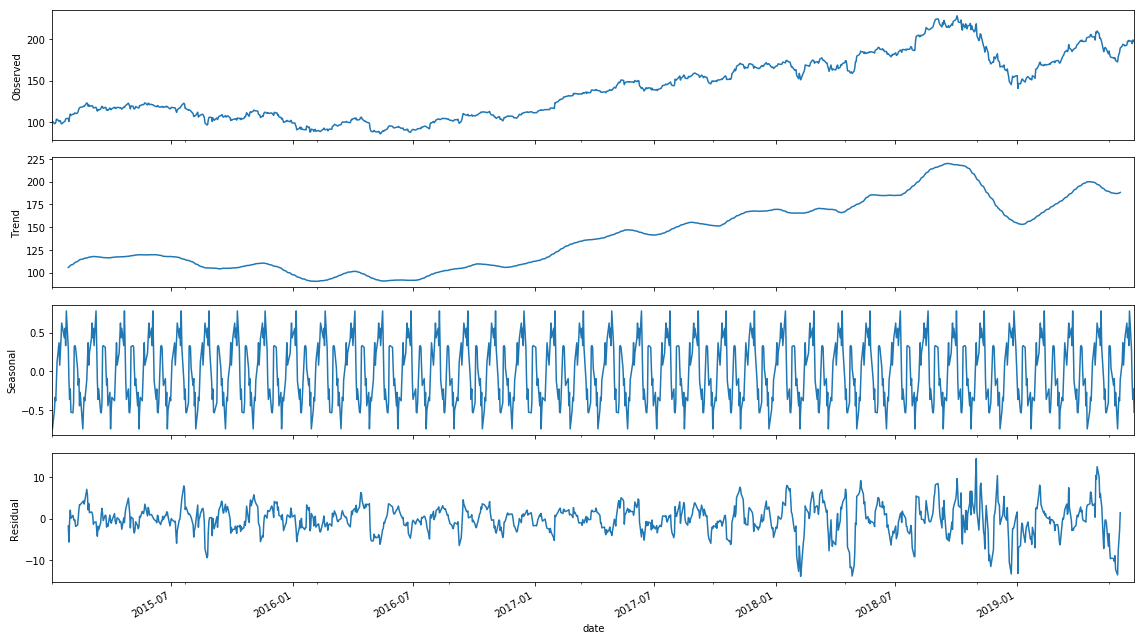

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
decomposed_df = sm.tsa.seasonal_decompose(train_df.adjclose,freq=30)
decomposed_df.plot();

In [24]:
fit1 = Holt(np.asarray(train_df.adjclose)).fit(smoothing_level=0.54, smoothing_slope=.2, optimized=True) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(test_df)) 

rms = np.sqrt(mean_squared_error(test_df.adjclose, y_hat_avg['Holt_linear'])) 

(train_df.adjclose.hvplot(legend = False, title = f'Moving Average, RMSE = {np.round(rms, 3)} ' , ylabel = 'Value') * 
 test_df.adjclose.hvplot(legend =False) *
y_hat_avg['Holt_linear'].hvplot(legend = False))

:Overlay
   .Curve.Adjclose.I  :Curve   [date]   (adjclose)
   .Curve.Adjclose.II :Curve   [date]   (adjclose)
   .Curve.Holt_linear :Curve   [date]   (Holt_linear)